In [1]:
%load_ext autoreload
%autoreload 2
import pointCollection as pc
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import h5py
%matplotlib notebook
from ATL11.RDE import RDE
import scipy.interpolate as si
import os
from ATL11.rtw_mask import rtw_mask_for_delta_time
data_root='/Volumes/ice2/ben/MAR/ATL11_with_corrections/'
PLOT_MAPS=False

#secular_correction='zsurf_mean'
#version='v2_zsurf'
secular_correction='smb_mean'
version='v2_SMB'

model_list=[ 'MARv3.11.2-ERA-6km','MARv3.11.2-ERA-20km',
           'MARv3.11.2-NCEP-20km', 'GSFC-fdm-v1.1']
#model_list=[ 'MARv3.11.2-ERA-6km', 'GSFC-fdm-v1.1' ]



In [2]:
#masks:
gimp_mask=pc.grid.data().from_geotif(data_root+'/GimpIceMask_1km.tif')
v_mask=pc.grid.data().from_geotif(data_root+'/vel_mask_annual_nmad_lt_20_simplified.tif')
drainage_basins=pc.grid.data().from_geotif(data_root+'/drainage_basins.tif')
db_mask=drainage_basins.copy()
db_mask.z=np.isfinite(db_mask.z)
temp=gimp_mask.interp(db_mask.x, db_mask.y, gridded=True)
db_mask.z[np.where(temp<0.5)]=0
temp=v_mask.interp(db_mask.x, db_mask.y, gridded=True)
db_mask.z[np.where(temp<0.5)]=0

temp=np.isfinite(drainage_basins.z).astype(float)-db_mask.z.astype(float)
F_eliminated = np.sum(temp!=0)/np.sum(np.isfinite(drainage_basins.z) & (drainage_basins.z>0))

print(f"Masking removed {100*F_eliminated}% of the ice sheet")

bounds=None
bounds=None
bounds=None
Masking removed 12.065316209479825% of the ice sheet


In [3]:
if PLOT_MAPS:
    fig=plt.figure(1); plt.clf()
    fig.clf(); hax=[]
    hax.append(fig.add_subplot(131))
    gimp_mask.show(ax=hax[0])
    hax[-1].set_title('ice and rock mask')
    hax.append(fig.add_subplot(132, sharex=hax[0], sharey=hax[0]))
    drainage_basins.show(ax=hax[1])
    hax[-1].set_title('drainage basins')
    hax.append(fig.add_subplot(133, sharex=hax[0], sharey=hax[0]))
    v_mask.show(ax=hax[2])
    hax[-1].set_title('velocity variability < 20 m/yr')

In [4]:
if PLOT_MAPS:
    fig=plt.figure(2); plt.clf()
    fig.clf(); hax=[]
    db_mask=drainage_basins.copy()
    db_mask.z=np.isfinite(db_mask.z)
    temp=gimp_mask.interp(db_mask.x, db_mask.y, gridded=True)
    hax.append(fig.add_subplot(131))
    plt.imshow(np.isfinite(drainage_basins.z).astype(float) -(temp<0.5).astype(float), origin='lower')
    db_mask.z[np.where(temp<0.5)]=0
    temp=v_mask.interp(db_mask.x, db_mask.y, gridded=True)
    hax.append(fig.add_subplot(132))
    plt.imshow(np.isfinite(drainage_basins.z).astype(float) -(temp<0.5).astype(float), origin='lower')
    db_mask.z[np.where(temp<0.5)]=0
    hax.append(fig.add_subplot(133))
    plt.imshow(np.isfinite(drainage_basins.z).astype(float)-db_mask.z.astype(float), origin='lower')



In [5]:
def safe_read(fh, group, field):
    temp=np.array(fh[group][field])
    temp[np.abs(temp) > 1.e15] = np.nan
    return temp

In [6]:
xo_file=data_root+'/temp/007_crossover_data_v1.h5'
#xo_file='/Volumes/ice1/tyler/U07_crossover_data.h5'
with h5py.File(xo_file,'r') as h5f:
    print(list(h5f.keys()))
    print(h5f['x'].shape)

xo_cols=7
xo_cycles=np.arange(8)
#at_file='/Volumes/ice1/tyler/relU07_dump_every_4th.h5'
at_file=data_root+'/temp/rel007_dump_every_4th.h5'
with h5py.File(at_file,'r') as h5f:
    print(list(h5f.keys()))
    print(h5f['x'].shape)

at_cols=5
at_cycles=np.arange(3, 8)

['GSFC-fdm-v1.1', 'MARv3.11.2-ERA-10km', 'MARv3.11.2-ERA-20km', 'MARv3.11.2-ERA-6km', 'MARv3.11.2-NCEP-20km', 'RACMO2.3p2-FGRN055', 'along_track_rss', 'atl06_quality_summary', 'cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'rgt', 'x', 'x_atc', 'y']
(27117906, 7, 2)
['GSFC-fdm-v1.1', 'MARv3.11.2-ERA-10km', 'MARv3.11.2-ERA-20km', 'MARv3.11.2-ERA-6km', 'MARv3.11.2-NCEP-20km', 'RACMO2.3p2-FGRN055', 'cycle_number', 'delta_time', 'dem_h', 'file_ind', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y']
(10984174, 5)


In [7]:
def read_corrections(file, model, D):
    with h5py.File(file,'r') as h5f:
        print(model)
        model_name=model.replace('.','_').replace('-','_')
        zsurf_name=model_name+'_zsurf'
        D.assign({zsurf_name:safe_read(h5f, model, 'zsurf')})
        FAC_name=model_name+'_z_FAC'
        try:
            D.assign({FAC_name:getattr(D, zsurf_name)-safe_read(h5f, model, 'SMB')/.910})
        except Exception as exc:            
            print(f"problem calculating zFAC for {model} using MAR params")
            try:
                print("\t using GSFC parameters instead")
                D.assign({FAC_name:getattr(D, zsurf_name)-safe_read(h5f, model, 'zsmb')})
            except Exception as exc:
                print("also had a problem reading the GSFC fields")
        for field in [ 'smb_mean', 'zsurf_mean']:#,'SMB', 'zsurf_ave',]
            if field in h5f[model]:
                fieldname=model_name+'_'+field
                D.assign({fieldname:safe_read(h5f, model, field)})
                print(f"{fieldname}:{np.mean(np.isfinite(getattr(D, fieldname)), axis=0)}")
        if 'SMB' in h5f[model]:
            field='SMB'
            fieldname=model_name+'_SMB'
            D.assign({fieldname:safe_read(h5f, model, 'SMB')})
            print(f"{fieldname}:{np.mean(np.isfinite(getattr(D, fieldname)), axis=0)}")
        elif 'zsmb' in h5f[model] and 'GSFC' in model:
            fieldname=model_name+'_SMB'
            D.assign({fieldname:safe_read(h5f, model, 'zsmb')})
            print(f"{model_name}:\n{np.mean(np.isfinite(getattr(D, fieldname)), axis=0)}")
        else:
            print(f'{model}: no SMB')        
        print("\n\n")
    return  

In [8]:
D_xo=pc.data(columns=xo_cols).from_h5(xo_file, field_dict={None:['along_track_rss', 'atl06_quality_summary', \
            'cycle_number','delta_time', 'h_corr', 'h_corr_sigma','fit_quality', \
            'latitude', 'ref_pt', 'rgt','x','y']})
# remove data for which the PS projection gave weird results
bad=np.abs(D_xo.x) > 1.e8
D_xo.x[bad]=np.nan
D_xo.x=np.nanmax(np.nanmax(D_xo.x, axis=1), axis=1)
D_xo.y[bad]=np.nan
D_xo.y=np.nanmax(np.nanmax(D_xo.y, axis=1), axis=1)

In [9]:
print("READING xover CORRECTIONS")
for model in model_list:
    read_corrections(xo_file, model, D_xo)
print(D_xo)
{field:getattr(D_xo, field).shape for field in D_xo.fields}

READING xover CORRECTIONS
MARv3.11.2-ERA-6km
MARv3_11_2_ERA_6km_smb_mean:[[0.         0.08539081]
 [0.         0.11331255]
 [0.23796    0.10365697]
 [0.13238301 0.07809523]
 [0.27707261 0.11225369]
 [0.29381852 0.11922713]
 [0.24697884 0.09531938]]
MARv3_11_2_ERA_6km_zsurf_mean:[[0.         0.08539081]
 [0.         0.11331255]
 [0.23796    0.10365697]
 [0.13238301 0.07809523]
 [0.27707261 0.11225369]
 [0.29381852 0.11922713]
 [0.24697884 0.09531938]]
MARv3_11_2_ERA_6km_SMB:[[0.         0.08539081]
 [0.         0.11331255]
 [0.23796    0.10365697]
 [0.13238301 0.07809523]
 [0.27707261 0.11225369]
 [0.29381852 0.11922713]
 [0.24697884 0.09531938]]



MARv3.11.2-ERA-20km
MARv3_11_2_ERA_20km_smb_mean:[[0.         0.08650277]
 [0.         0.1143485 ]
 [0.24021405 0.10447016]
 [0.13357141 0.07881859]
 [0.27971625 0.11316549]
 [0.29688845 0.12028945]
 [0.24912396 0.09608179]]
MARv3_11_2_ERA_20km_zsurf_mean:[[0.         0.08650277]
 [0.         0.1143485 ]
 [0.24021405 0.10447016]
 [0.13357141

{'along_track_rss': (27117906, 7, 2),
 'atl06_quality_summary': (27117906, 7, 2),
 'cycle_number': (27117906, 7, 2),
 'delta_time': (27117906, 7, 2),
 'h_corr': (27117906, 7, 2),
 'h_corr_sigma': (27117906, 7, 2),
 'fit_quality': (27117906, 7, 2),
 'latitude': (27117906, 7, 2),
 'ref_pt': (27117906, 7, 2),
 'rgt': (27117906, 7, 2),
 'x': (27117906,),
 'y': (27117906,),
 'MARv3_11_2_ERA_6km_zsurf': (27117906, 7, 2),
 'MARv3_11_2_ERA_6km_z_FAC': (27117906, 7, 2),
 'MARv3_11_2_ERA_6km_smb_mean': (27117906, 7, 2),
 'MARv3_11_2_ERA_6km_zsurf_mean': (27117906, 7, 2),
 'MARv3_11_2_ERA_6km_SMB': (27117906, 7, 2),
 'MARv3_11_2_ERA_20km_zsurf': (27117906, 7, 2),
 'MARv3_11_2_ERA_20km_z_FAC': (27117906, 7, 2),
 'MARv3_11_2_ERA_20km_smb_mean': (27117906, 7, 2),
 'MARv3_11_2_ERA_20km_zsurf_mean': (27117906, 7, 2),
 'MARv3_11_2_ERA_20km_SMB': (27117906, 7, 2),
 'MARv3_11_2_NCEP_20km_zsurf': (27117906, 7, 2),
 'MARv3_11_2_NCEP_20km_z_FAC': (27117906, 7, 2),
 'MARv3_11_2_NCEP_20km_smb_mean': (27117906

In [10]:
D_at=pc.data(columns=at_cols).from_h5(at_file, \
            field_dict={None:['x','y','delta_time','quality_summary','fit_quality','h_corr','h_corr_sigma','dem_h','rgt']})

In [11]:
print("READING ALONG-TRACK CORRECTIONS")
for model in model_list:
    read_corrections(at_file, model, D_at)
print(D_at)
{field:getattr(D_at, field).shape for field in D_at.fields}

READING ALONG-TRACK CORRECTIONS
MARv3.11.2-ERA-6km
MARv3_11_2_ERA_6km_smb_mean:[0.49744733 0.28739849 0.57648358 0.61722028 0.51118609]
MARv3_11_2_ERA_6km_zsurf_mean:[0.49744733 0.28739849 0.57648358 0.61722028 0.51118609]
MARv3_11_2_ERA_6km_SMB:[0.49744733 0.28739849 0.57648358 0.61722028 0.51118609]



MARv3.11.2-ERA-20km
MARv3_11_2_ERA_20km_smb_mean:[0.50147093 0.2895484  0.58117998 0.62282289 0.51496681]
MARv3_11_2_ERA_20km_zsurf_mean:[0.50147093 0.2895484  0.58117998 0.62282289 0.51496681]
MARv3_11_2_ERA_20km_SMB:[0.50147093 0.2895484  0.58117998 0.62282289 0.51496681]



MARv3.11.2-NCEP-20km
MARv3_11_2_NCEP_20km_smb_mean:[0.50147093 0.2895484  0.58117998 0.62282289 0.51496681]
MARv3_11_2_NCEP_20km_zsurf_mean:[0.50147093 0.2895484  0.58117998 0.62282289 0.51496681]
MARv3_11_2_NCEP_20km_SMB:[0.50147093 0.2895484  0.58117998 0.62282289 0.51496681]



GSFC-fdm-v1.1
problem calculating zFAC for GSFC-fdm-v1.1 using MAR params
	 using GSFC parameters instead
GSFC_fdm_v1_1:
[0.63006595 0

{'x': (10984174, 5),
 'y': (10984174, 5),
 'delta_time': (10984174, 5),
 'quality_summary': (10984174, 5),
 'fit_quality': (10984174, 5),
 'h_corr': (10984174, 5),
 'h_corr_sigma': (10984174, 5),
 'dem_h': (10984174, 5),
 'rgt': (10984174, 5),
 'MARv3_11_2_ERA_6km_zsurf': (10984174, 5),
 'MARv3_11_2_ERA_6km_z_FAC': (10984174, 5),
 'MARv3_11_2_ERA_6km_smb_mean': (10984174, 5),
 'MARv3_11_2_ERA_6km_zsurf_mean': (10984174, 5),
 'MARv3_11_2_ERA_6km_SMB': (10984174, 5),
 'MARv3_11_2_ERA_20km_zsurf': (10984174, 5),
 'MARv3_11_2_ERA_20km_z_FAC': (10984174, 5),
 'MARv3_11_2_ERA_20km_smb_mean': (10984174, 5),
 'MARv3_11_2_ERA_20km_zsurf_mean': (10984174, 5),
 'MARv3_11_2_ERA_20km_SMB': (10984174, 5),
 'MARv3_11_2_NCEP_20km_zsurf': (10984174, 5),
 'MARv3_11_2_NCEP_20km_z_FAC': (10984174, 5),
 'MARv3_11_2_NCEP_20km_smb_mean': (10984174, 5),
 'MARv3_11_2_NCEP_20km_zsurf_mean': (10984174, 5),
 'MARv3_11_2_NCEP_20km_SMB': (10984174, 5),
 'GSFC_fdm_v1_1_zsurf': (10984174, 5),
 'GSFC_fdm_v1_1_z_FAC': 

In [12]:
D_xo.index((D_xo.x > drainage_basins.x[0]) & (D_xo.x < drainage_basins.x[-1]) & (D_xo.y > drainage_basins.y[0]) & (D_xo.y < drainage_basins.y[-1]))
D_at.index((D_at.x[:,0] > drainage_basins.x[0]) & (D_at.x[:,0] < drainage_basins.x[-1]) & (D_at.y[:,0] > drainage_basins.y[0]) & (D_at.y[:,0] < drainage_basins.y[-1]))

dbi=si.RegularGridInterpolator((drainage_basins.y, drainage_basins.x), drainage_basins.z, method='nearest')
D_xo.assign({'basin':np.round(dbi.__call__((D_xo.y, D_xo.x))*10)/10})
D_at.assign({'basin':np.round(dbi.__call__((D_at.y[:,0], D_at.x[:,0]))*10)/10});

In [13]:
# mask out non-ice areas
D_at.assign({'ice_mask':np.round(gimp_mask.interp(D_at.x[:,0], D_at.y[:,0])*10)/10});
D_xo.assign({'ice_mask':np.round(gimp_mask.interp(D_xo.x, D_xo.y)*10)/10})

<class 'pointCollection.data.data'> with shape (10122736, 7, 2),
with fields:
['along_track_rss', 'atl06_quality_summary', 'cycle_number', 'delta_time', 'h_corr', 'h_corr_sigma', 'fit_quality', 'latitude', 'ref_pt', 'rgt', 'x', 'y', 'MARv3_11_2_ERA_6km_zsurf', 'MARv3_11_2_ERA_6km_z_FAC', 'MARv3_11_2_ERA_6km_smb_mean', 'MARv3_11_2_ERA_6km_zsurf_mean', 'MARv3_11_2_ERA_6km_SMB', 'MARv3_11_2_ERA_20km_zsurf', 'MARv3_11_2_ERA_20km_z_FAC', 'MARv3_11_2_ERA_20km_smb_mean', 'MARv3_11_2_ERA_20km_zsurf_mean', 'MARv3_11_2_ERA_20km_SMB', 'MARv3_11_2_NCEP_20km_zsurf', 'MARv3_11_2_NCEP_20km_z_FAC', 'MARv3_11_2_NCEP_20km_smb_mean', 'MARv3_11_2_NCEP_20km_zsurf_mean', 'MARv3_11_2_NCEP_20km_SMB', 'GSFC_fdm_v1_1_zsurf', 'GSFC_fdm_v1_1_z_FAC', 'GSFC_fdm_v1_1_SMB', 'basin', 'ice_mask']

In [14]:
# mask based on the speed variability
D_at.assign({'vel_mask':np.round(v_mask.interp(D_at.x[:,0], D_at.y[:,0])*10)/10});
D_xo.assign({'vel_mask':np.round(v_mask.interp(D_xo.x, D_xo.y)*10)/10});

In [15]:
# filter bad dh values from D_at
bad=(np.abs(D_at.h_corr-D_at.dem_h)>100) | np.tile(np.abs(D_at.ice_mask[:, None]-1)>0.01, [1, at_cols]) 
bad |= np.tile(np.abs(D_at.vel_mask[:, None]-1)>0.01, [1, at_cols]) 
bad |= np.tile(~np.isfinite(D_at.basin[:, None]), [1,5])
bad |= D_at.fit_quality > 0
bad |= rtw_mask_for_delta_time(D_at.delta_time, csv_file='/home/ben/git_repos/ATL11/ICESat-2_TechRefTable_08282020_RTWs.csv')==0
print('filtering'+str(np.mean(bad)))
D_at.h_corr[bad]=np.nan

filtering0.4452026414263196


In [16]:
# filter bad dh values from D_xo
bad= np.tile(np.abs(D_xo.ice_mask[:, None]-1)>0.01, [1, xo_cols]) 
bad |= np.tile(np.abs(D_xo.vel_mask[:, None]-1)>0.01, [1, xo_cols]) 
bad |= np.tile(~np.isfinite(D_xo.basin[:, None]), [1, xo_cols])
bad |= np.any(D_xo.atl06_quality_summary==1, axis=2)
bad |= np.any(D_xo.fit_quality>0, axis=2)
bad |= np.any(rtw_mask_for_delta_time(D_xo.delta_time, csv_file='/home/ben/git_repos/ATL11/ICESat-2_TechRefTable_08282020_RTWs.csv')==0, axis=2)
print('editing '+str(np.mean(bad)))
temp=D_xo.h_corr.copy()
temp[:,:,0][bad]=np.nan
temp[:,:,1][bad]=np.nan
D_xo.h_corr=temp
#np.mean(bad[np.isfinite(D_xo.h_corr)])
#D_xo.h_corr[bad]=np.nan

editing 0.45248142399446156


In [17]:
np.nanmean(D_xo.fit_quality==0)

0.3240168609412656

In [18]:
def reduce_data(D, epoch_slices, model, d_delta_t, block_scale):
    out={}
    for epoch, slices in epoch_slices.items():
        s0, s1=slices
        dh=pc.data()
        dh.assign({'h0':0.5*(D.h_corr[s1]+D.h_corr[s0]),
                   'data':(D.h_corr[s1]-D.h_corr[s0]),
                   'basin':D.basin.copy()})                          
        if len(D.x.shape) > 1:
            dh.assign({'x':D.x[:,0].copy(),\
                'y':D.y[:,0].copy()})
        else:
            dh.assign({'x':D.x.copy(),\
                'y':D.y.copy()})
        for in_field, out_field in {'zsurf':'model', 'z_FAC':'fac', 'SMB':'smb'}.items():
            temp=getattr(D, model+'_'+in_field)
            dh.assign({out_field:temp[s1]-temp[s0]})

        smb_mean_field=model+'_'+secular_correction
        if 'GSFC' not in model:
            if smb_mean_field not in D.fields:
                #if 'NCEP' in model:
                #    smb_mean_field = 'MARv3_11_2_NCEP_20km_zsurf'
                #else:
                #    smb_mean_field = 'MARv3_11_2_ERA_10km_zsurf'
                print(f'MISSING: {smb_mean_field}')
            dt_data = (D.delta_time[s1]-D.delta_time[s0])/24/3600/365.25
            dh.assign({'mean': dt_data * getattr(D, smb_mean_field)[s0]/.910})
            dh.model -= dh.mean            
            dh.smb -= dh.mean

            print(f'data valid: {np.mean(np.isfinite(dh.data))}, mean valid: {np.mean(np.isfinite(dh.mean))}')
        else:
            #GSFC is already corrected
            dh.assign({'mean':np.zeros_like(dh.model)})

        dh.assign({'corrected': dh.data-dh.model})
        dh.assign({'t0':D.delta_time[s0], 't1':D.delta_time[s1]})

        good=np.isfinite(dh.corrected)
        dh.index(good)

        # blockmedian in short-time increments:
        t_bin=np.round(dh.t0/d_delta_t)
        ut_bin=np.unique(t_bin[np.isfinite(t_bin)])
        ii=[]
        for ti in ut_bin:
            these=np.flatnonzero(t_bin==ti)
            temp=these[pc.pt_blockmedian(dh.x[these], dh.y[these], dh.corrected[these], block_scale, index_only=True)]
            ii += [temp]
        ii=np.concatenate(ii, axis=0)
        for field in ['x','y', 'data','model','mean','corrected','h0','fac','smb', 'basin', 't0', 't1']:
            temp=getattr(dh, field)
            setattr(dh, field, 0.5*(temp[ii[:,0]]+temp[ii[:,1]]))
        out[epoch]=dh
    return out

In [19]:
d_delta_t = 10*24*3600
block_scale=2500

In [20]:
[field for field in D_xo.fields if '6km' in field]

['MARv3_11_2_ERA_6km_zsurf',
 'MARv3_11_2_ERA_6km_z_FAC',
 'MARv3_11_2_ERA_6km_smb_mean',
 'MARv3_11_2_ERA_6km_zsurf_mean',
 'MARv3_11_2_ERA_6km_SMB']

In [21]:
epoch_slices = {'2018.Q4-2019.Q2':[np.s_[:,0,1],\
                                   np.s_[:, 2, 0]],
                '2019.Q1-2019.Q2':[np.s_[:,1,1],\
                                   np.s_[:, 2, 0]]}
delta_data={}
for model in model_list:
    model=model.replace('.','_').replace('-','_')
    print(model)
    delta_data[model]=reduce_data(D_xo, epoch_slices, model, d_delta_t, block_scale)

MARv3_11_2_ERA_6km
data valid: 0.07680947127337906, mean valid: 0.14898610415207905
data valid: 0.10018951398120034, mean valid: 0.19540507625606357
MARv3_11_2_ERA_20km
data valid: 0.07680947127337906, mean valid: 0.1505220525359942
data valid: 0.10018951398120034, mean valid: 0.19677101131551786
MARv3_11_2_NCEP_20km
data valid: 0.07680947127337906, mean valid: 0.1505220525359942
data valid: 0.10018951398120034, mean valid: 0.19677101131551786
GSFC_fdm_v1_1


In [22]:
epoch_slices = {'2019.Q2-2019.Q3':[np.s_[:,0], np.s_[:,1]], \
                '2019.Q3-2019.Q4':[np.s_[:,1], np.s_[:,2]], \
                '2019.Q4-2020.Q1':[np.s_[:,2], np.s_[:,3]]}
for model in model_list:
    model=model.replace('.','_').replace('-','_')
    print(model)
    delta_data[model].update(reduce_data(D_at, epoch_slices, model, d_delta_t, block_scale))

MARv3_11_2_ERA_6km
data valid: 0.14195371925730443, mean valid: 0.23345557473105263
data valid: 0.165078103569537, mean valid: 0.2733692217361576
data valid: 0.3499810513373615, mean valid: 0.5821419062182093
MARv3_11_2_ERA_20km
data valid: 0.14195371925730443, mean valid: 0.23458927407932215
data valid: 0.165078103569537, mean valid: 0.2750984669122996
data valid: 0.3499810513373615, mean valid: 0.5864378181952017
MARv3_11_2_NCEP_20km
data valid: 0.14195371925730443, mean valid: 0.23458927407932215
data valid: 0.165078103569537, mean valid: 0.2750984669122996
data valid: 0.3499810513373615, mean valid: 0.5864378181952017
GSFC_fdm_v1_1


In [37]:
D_at

<class 'pointCollection.data.data'> with shape (8694545, 5),
with fields:
['x', 'y', 'delta_time', 'quality_summary', 'fit_quality', 'h_corr', 'h_corr_sigma', 'dem_h', 'rgt', 'MARv3_11_2_ERA_6km_zsurf', 'MARv3_11_2_ERA_6km_z_FAC', 'MARv3_11_2_ERA_6km_smb_mean', 'MARv3_11_2_ERA_6km_zsurf_mean', 'MARv3_11_2_ERA_6km_SMB', 'MARv3_11_2_ERA_20km_zsurf', 'MARv3_11_2_ERA_20km_z_FAC', 'MARv3_11_2_ERA_20km_smb_mean', 'MARv3_11_2_ERA_20km_zsurf_mean', 'MARv3_11_2_ERA_20km_SMB', 'MARv3_11_2_NCEP_20km_zsurf', 'MARv3_11_2_NCEP_20km_z_FAC', 'MARv3_11_2_NCEP_20km_smb_mean', 'MARv3_11_2_NCEP_20km_zsurf_mean', 'MARv3_11_2_NCEP_20km_SMB', 'GSFC_fdm_v1_1_zsurf', 'GSFC_fdm_v1_1_z_FAC', 'GSFC_fdm_v1_1_SMB', 'basin', 'ice_mask', 'vel_mask']

<IPython.core.display.Javascript object>


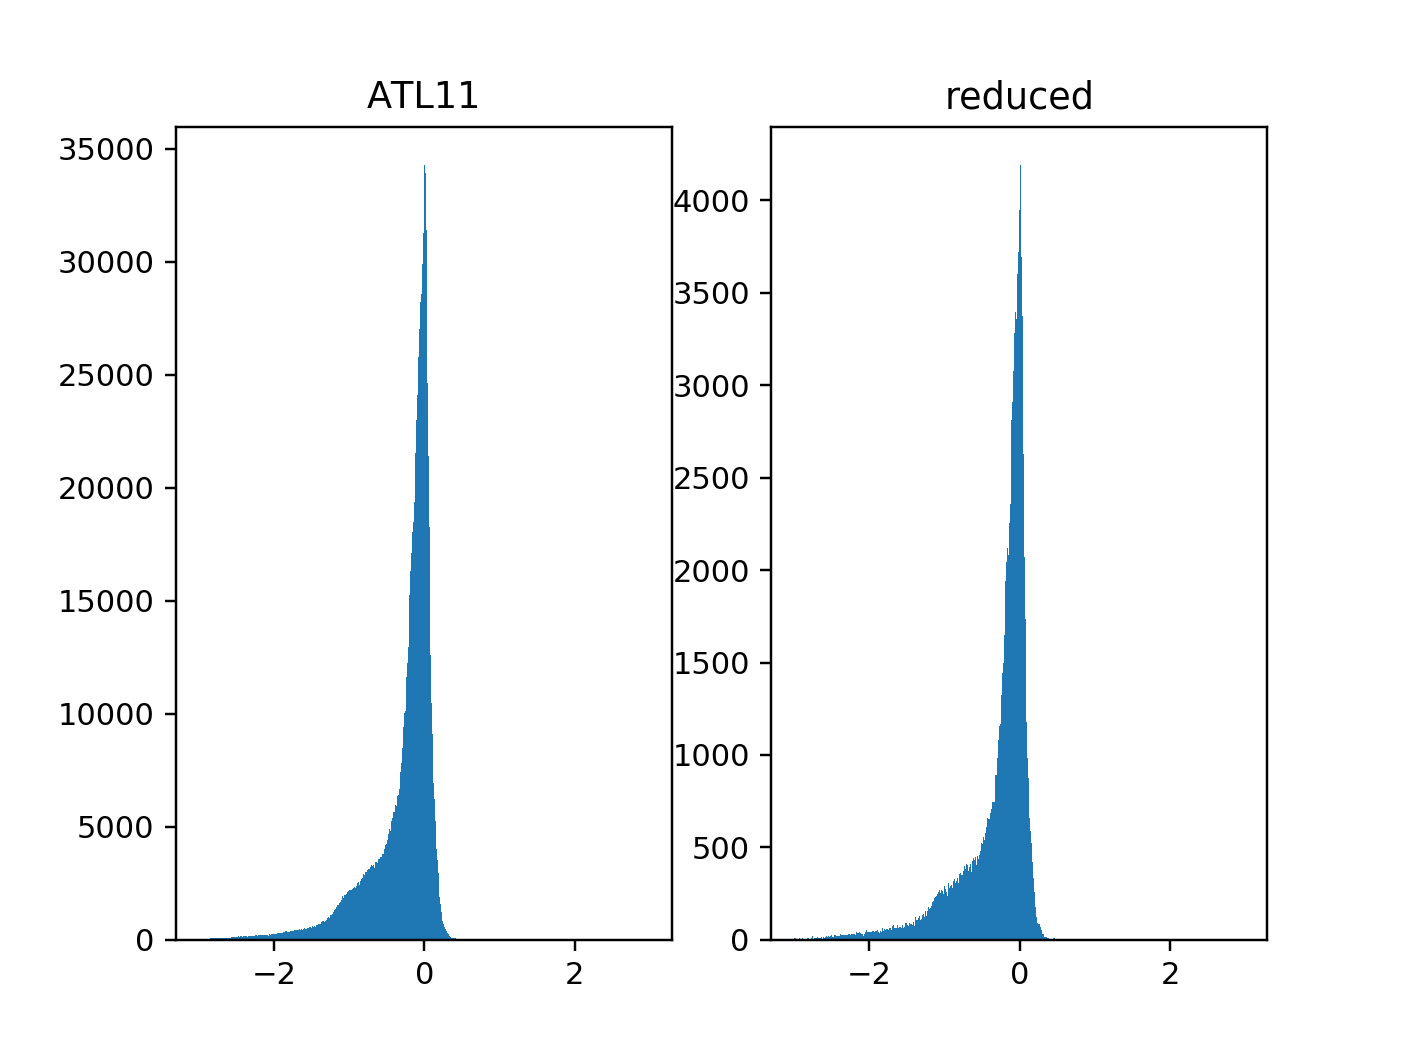

Text(0.5, 1.0, 'reduced')

In [39]:
# make sure the digested data look enough like the raw data

this_model=model_list[0].replace('.','_').replace('-','_')
fig=plt.figure()
fig.add_subplot(121)
plt.hist(D_at.h_corr[:,1]-D_at.h_corr[:,0], np.arange(-3, 3, 0.01))
plt.title('ATL11')
fig.add_subplot(122)
plt.hist(delta_data[this_model]['2019.Q2-2019.Q3'].data, np.arange(-3, 3, 0.01))
plt.title('reduced')

In [23]:
# pull out the cycle-3 corrections
epoch_slices = {'2019.Q2-2019.Q3':[np.s_[:,0], np.s_[:,1]], \
                '2019.Q2-2019.Q4':[np.s_[:,0], np.s_[:,2]], \
                '2019.Q2-2020.Q1':[np.s_[:,0], np.s_[:,3]]}
xover_epochs=['2018.Q4-2019.Q2', '2019.Q1-2019.Q2']
# these are the same for the crossover cycles
delta_data_c3={}
for model in delta_data.keys():
    delta_data_c3[model]={}
    for epoch in xover_epochs:
        delta_data_c3[model][epoch] = delta_data[model][epoch].copy()

for model in model_list:
    model=model.replace('.','_').replace('-','_')
    print(model)
    delta_data_c3[model].update(reduce_data(D_at, epoch_slices, model, d_delta_t, block_scale))

MARv3_11_2_ERA_6km
data valid: 0.14195371925730443, mean valid: 0.23345557473105263
data valid: 0.28089957553845546, mean valid: 0.4668360448994168
data valid: 0.31207625010854506, mean valid: 0.5133111623437454
MARv3_11_2_ERA_20km
data valid: 0.14195371925730443, mean valid: 0.23458927407932215
data valid: 0.28089957553845546, mean valid: 0.46994500574785686
data valid: 0.31207625010854506, mean valid: 0.5167719529889143
MARv3_11_2_NCEP_20km
data valid: 0.14195371925730443, mean valid: 0.23458927407932215
data valid: 0.28089957553845546, mean valid: 0.46994500574785686
data valid: 0.31207625010854506, mean valid: 0.5167719529889143
GSFC_fdm_v1_1


### Plot each epoch

<IPython.core.display.Javascript object>


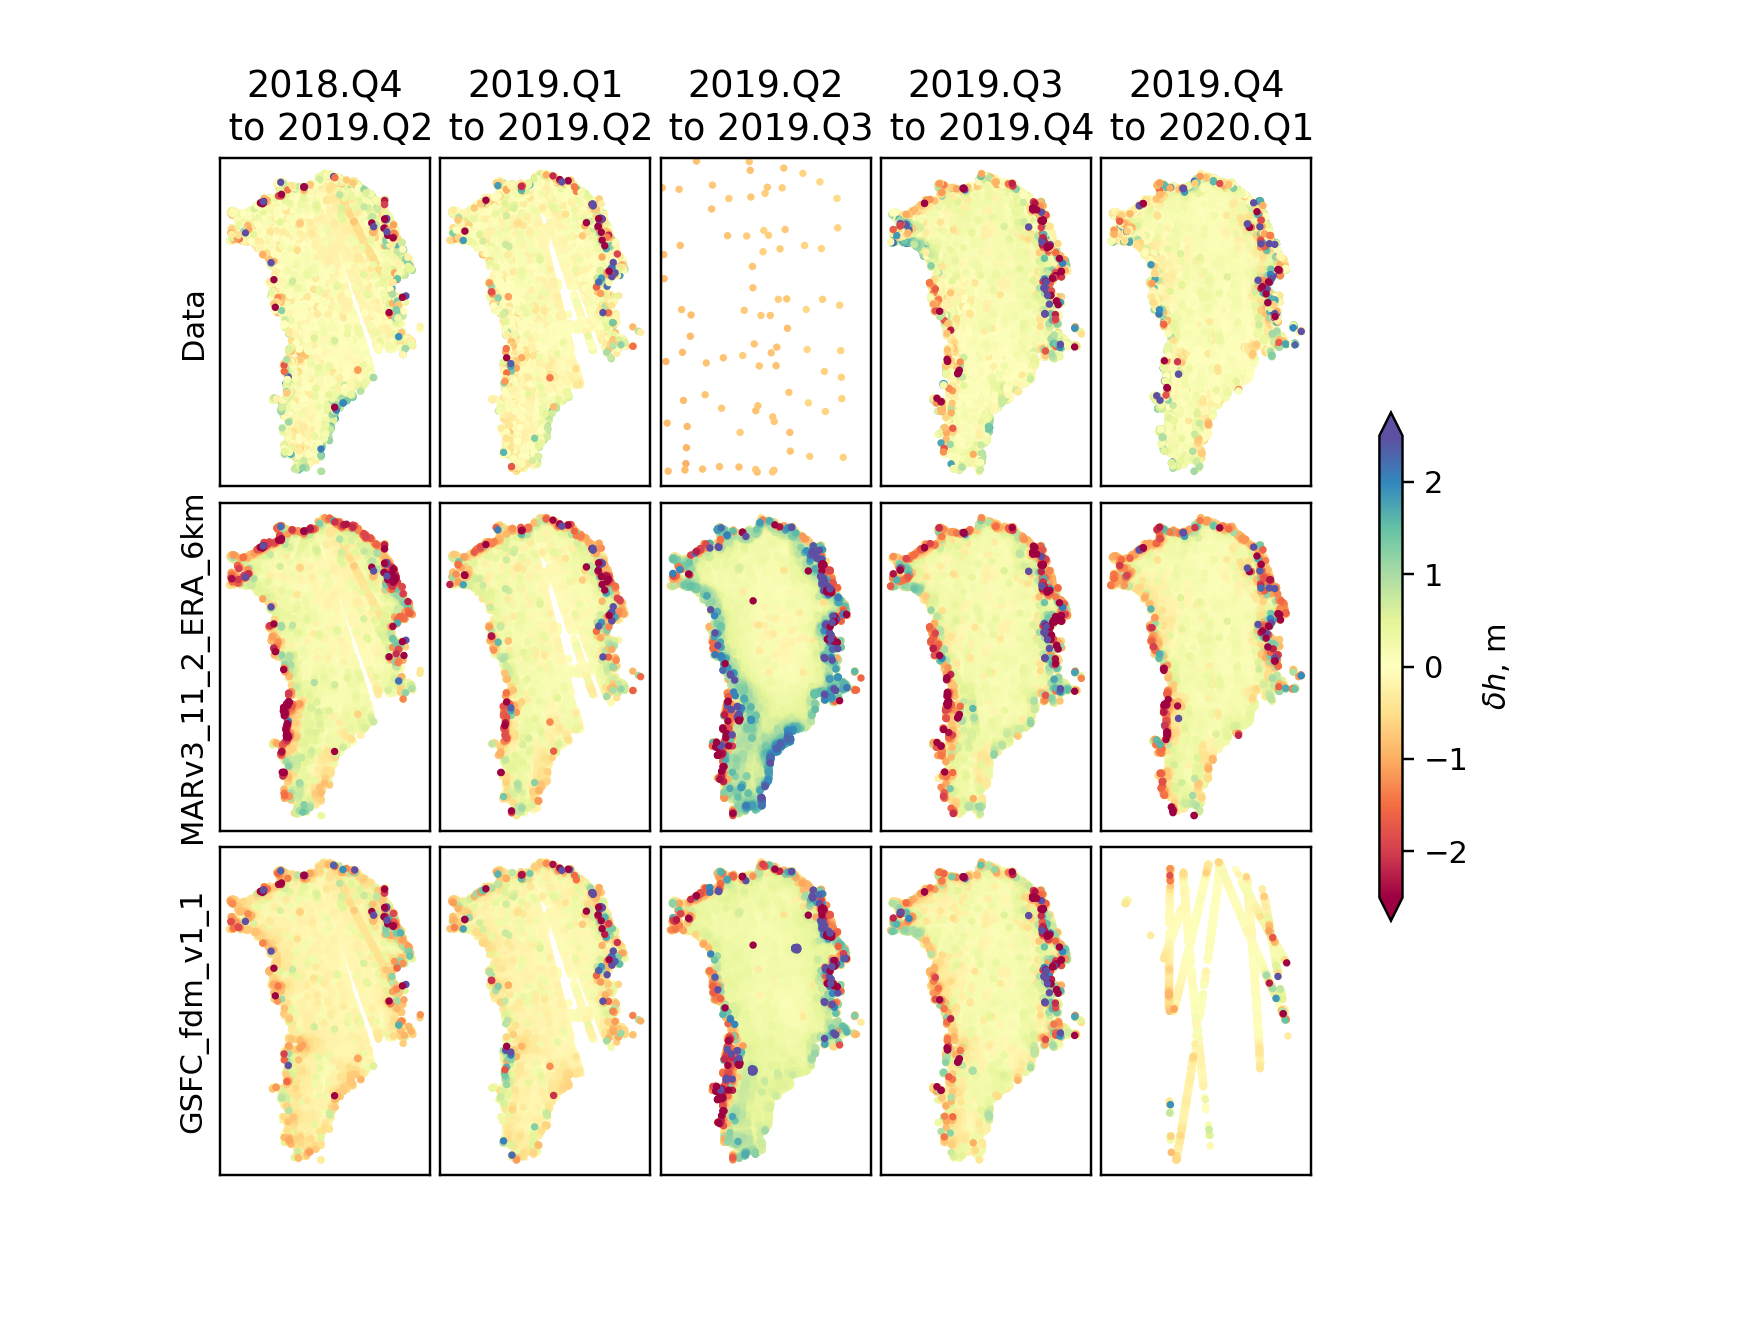

In [41]:
fig=plt.figure( figsize=[8, 6])
ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=xover_epochs+['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']

for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km', 'GSFC_fdm_v1_1']):
    for col, epoch in enumerate(strings):
        if row==0:
            ax[row, col].set_title(epoch.replace('-','\n to '))
        if col==0:
            ax[row, col].set_ylabel(model)
        if model == 'Data':
            D=delta_data['MARv3_11_2_ERA_6km']
            temp=D[epoch]
            dh=temp.data
        else:
            D=delta_data[model]
            temp=D[epoch]            
            dh=D[epoch].corrected   
        ind=np.argsort(np.abs(D[epoch].corrected))    
        hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 1, c=dh[ind],\
                 vmin=-2.5, vmax=2.5, cmap='Spectral');
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m');

In [43]:
np.diff(np.array(ax[0, 2].get_xlim()))

array([40691.93332451])

In [30]:
out_file=data_root+f'/combined_xover_at_differences_{version}.h5'
if os.path.isfile(out_file):
    os.remove(out_file)
for model in delta_data.keys():
    for epoch in delta_data[model]:
        delta_data[model][epoch].to_h5(out_file, group='/'+model+'/'+epoch, replace=False)

<IPython.core.display.Javascript object>


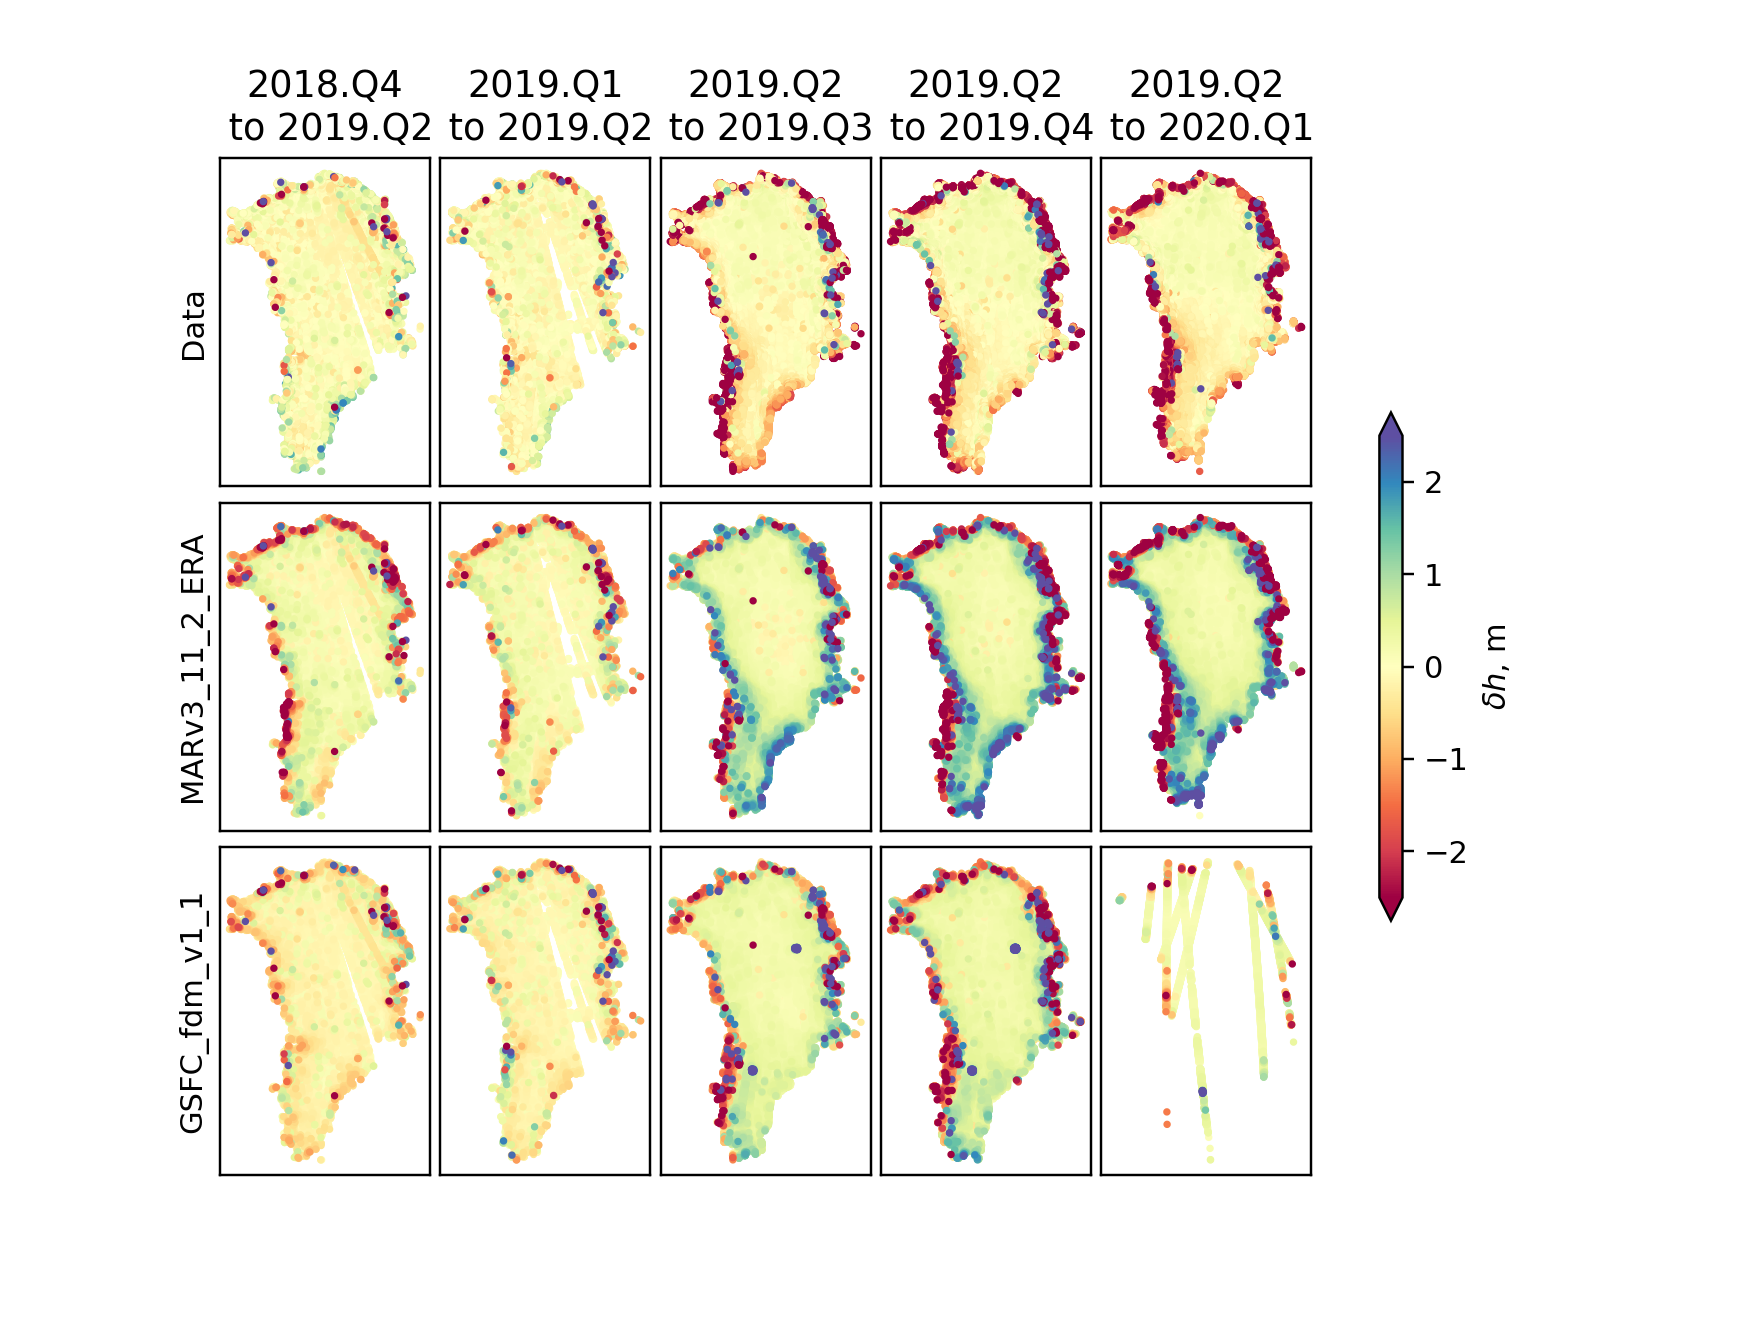

In [31]:

fig=plt.figure(22, figsize=[8, 6])
ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=xover_epochs+['2019.Q2-2019.Q3', '2019.Q2-2019.Q4', '2019.Q2-2020.Q1']

for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km', 'GSFC_fdm_v1_1']):
    for col, epoch in enumerate(strings):
        if row==0:
            ax[row, col].set_title(epoch.replace('-','\n to '))
        if col==0:
            ax[row, col].set_ylabel(model.replace('_zsurf','').replace('_6km',''))
        if model == 'Data':
            D=delta_data_c3['MARv3_11_2_ERA_6km']
            temp=D[epoch]
            dh=temp.data
        else:
            D=delta_data_c3[model]
            temp=D[epoch]            
            dh=D[epoch].corrected     
        ind=np.argsort(np.abs(D[epoch].corrected))    
        hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 2, c=dh[ind],\
                 vmin=-2.5, vmax=2.5, cmap='Spectral');
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m');



In [32]:
out_file=data_root+f'/combined_xover_at_differences_wrtc3_{version}.h5'
if os.path.isfile(out_file):
    os.remove(out_file)
for model in delta_data_c3.keys():
    for epoch in delta_data_c3[model]:
        delta_data_c3[model][epoch].to_h5(out_file, group='/'+model+'/'+epoch, replace=False)

In [ ]:
! ls -lt /Volumes/ice2/ben/MAR/ATL11_with_corrections//combined_xover_at_differences_*


In [44]:
! ls -l {out_file}

-rw-r--r-- 1 ben ben 219705964 Oct  8 23:30 /Volumes/ice2/ben/MAR/ATL11_with_corrections//combined_xover_at_differences_wrtc3_v2_SMB.h5
